In [1]:
# PyTorch and torchvision
import torch
import torchvision

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# GPU 확인 + 재현성 고정(선택)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

SEED = 42
import random
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

Using device: cuda


In [3]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms

dataset_dir = "data/Images/"

# ⚠️ 원본은 PIL로 유지: transform=None
full_dataset = ImageFolder(root=dataset_dir, transform=None)

total_size = len(full_dataset)
train_size = int(0.583 * total_size)  # 약 12,000개
test_size = total_size - train_size   # 약 8,580개

# 고정 시드로 split
gen = torch.Generator().manual_seed(SEED)
ds_train, ds_test = random_split(full_dataset, [train_size, test_size], generator=gen)

ds_info = {
    "num_classes": len(full_dataset.classes),
    "class_names": full_dataset.classes
}
print(f"Classes ({ds_info['num_classes']}): {ds_info['class_names']}")
print(f"Train size={len(ds_train)}, Test size={len(ds_test)}")

Classes (120): ['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier', 'n02093754-Border_terrier', 'n02093859-Kerry_blue_terrier', 'n02093991-Irish_terrier', 'n02094114-Norfolk_terrier', 'n02094258-Norwich_terrier', 'n02094

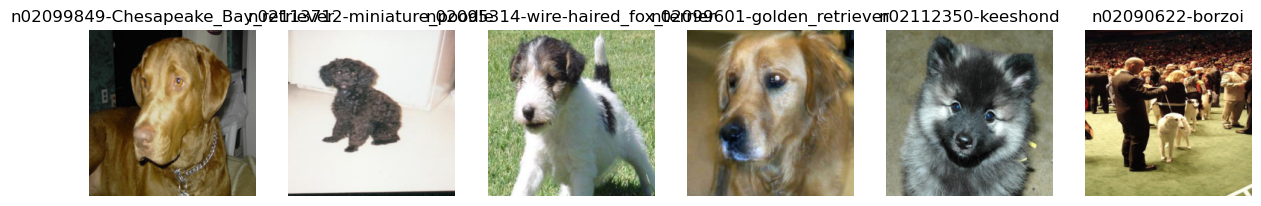

In [4]:
# Subset 전용 transform 래퍼 + 샘플 시각화
from torch.utils.data import Dataset

class TransformSubset(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
        self.classes = subset.dataset.classes
        self.class_to_idx = subset.dataset.class_to_idx

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        # 원본 ImageFolder는 PIL Image 반환 (transform=None)
        img, label = self.subset.dataset[self.subset.indices[idx]]
        img = self.transform(img)
        return img, label

# DataLoader에서 일부 배치 가져오기 (시각화 전용)
def show_examples(subset, class_names, num_images=6):
    vis_tf = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    preview_ds = TransformSubset(subset, vis_tf)
    preview_loader = DataLoader(preview_ds, batch_size=num_images, shuffle=True)
    images, labels = next(iter(preview_loader))

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        image = images[i].permute(1, 2, 0).numpy()
        image = np.clip(image, 0, 1)
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(class_names[labels[i].item()])

    plt.show()

# 훈련 데이터 샘플 시각화
show_examples(ds_train, ds_info["class_names"])

In [5]:
# 기본 전처리(무증강)
def normalize_and_resize_img():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

In [6]:
# 증강 파이프라인 (PIL 단계에서만 변환 → ToTensor/Normalize)
import random
from torchvision.transforms import functional as F

def augment():
    return transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        # 도메인에 따라 성능 하락 가능 → 필요시만 사용
        # transforms.RandomVerticalFlip(p=0.5),
        transforms.Lambda(lambda img: F.rotate(img, random.choice([0, 90, 180, 270]))),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

In [7]:
# 데이터셋을 가공하는 메인함수 (원본 transform 덮어쓰기 금지)
def apply_normalize_on_dataset(subset, is_test=False, batch_size=32, with_aug=False):
    tf = augment() if (not is_test and with_aug) else normalize_and_resize_img()
    wrapped = TransformSubset(subset, tf)
    pin = (device == "cuda")
    return DataLoader(wrapped, batch_size=batch_size, shuffle=not is_test, num_workers=2, pin_memory=pin)

# 비교 실험(Ablation Study)

In [8]:
# Model 정의 (ResNet50) — CrossEntropyLoss 사용 시 Softmax 금지
import torch.nn as nn
import torchvision.models as models

num_classes = len(ds_info["class_names"])

def build_resnet50(num_classes: int):
    m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

model_no_aug = build_resnet50(num_classes)      # 무증강용
model_aug = build_resnet50(num_classes)  # 증강용

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 61.0MB/s]


In [9]:
# DataLoaders 생성 (덮어쓰기 없이 안전)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False, batch_size=32)
ds_train_aug    = apply_normalize_on_dataset(ds_train, with_aug=True,  batch_size=32)
ds_test_loader  = apply_normalize_on_dataset(ds_test,  is_test=True,   batch_size=32)

len(ds_train_no_aug), len(ds_train_aug), len(ds_test_loader)

(375, 375, 269)

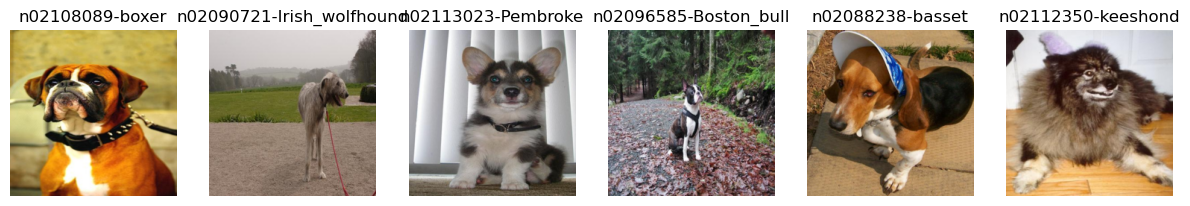

In [12]:
# 빠른 점검을 위한 배치 시각화
def denorm_and_show_batch(images, labels, class_names, n=6):
    imgs = images[:n].cpu() * 0.5 + 0.5
    imgs = torch.clamp(imgs, 0, 1)
    fig, axes = plt.subplots(1, n, figsize=(15, 4))
    for i in range(n):
        axes[i].imshow(np.transpose(imgs[i].numpy(), (1, 2, 0)))
        axes[i].set_title(class_names[labels[i].item()])
        axes[i].axis('off')
    plt.show()

batch_imgs, batch_lbls = next(iter(ds_train_no_aug))
denorm_and_show_batch(batch_imgs, batch_lbls, ds_info["class_names"])

In [13]:
# 학습/평가 공통 함수 + 옵티마이저
import torch.optim as optim

EPOCH = 15
criterion = nn.CrossEntropyLoss()

opt_no_aug = optim.SGD(model_no_aug.parameters(), lr=0.001, momentum=0.9)
opt_aug    = optim.SGD(model_aug.parameters(), lr=0.001, momentum=0.9)

@torch.no_grad()
def evaluate(model, loader, device="cuda"):
    model.eval()
    correct, total = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        pred = logits.argmax(dim=1)
        total += y.size(0)
        correct += (pred == y).sum().item()
    return 100.0 * correct / total

def train(model, optimizer, train_loader, test_loader, epochs, device="cuda"):
    model.to(device)
    history = {'val_accuracy': []}
    for epoch in range(1, epochs+1):
        model.train()
        correct = total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)           # logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            pred = outputs.argmax(dim=1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()

        train_acc = 100. * correct / total
        val_acc = evaluate(model, test_loader, device=device)
        history['val_accuracy'].append(val_acc)
        print(f"Epoch [{epoch}/{epochs}] | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")
    return history

In [14]:
%%time
# 학습 실행 (증강 vs 무증강)
history_basic_aug    = train(model_aug, opt_aug,    ds_train_aug,    ds_test_loader, EPOCH, device)
history_no_aug = train(model_no_aug,     opt_no_aug, ds_train_no_aug, ds_test_loader, EPOCH, device)

Epoch [1/15] | Train Acc: 28.37% | Val Acc: 67.23%
Epoch [2/15] | Train Acc: 58.98% | Val Acc: 76.78%
Epoch [3/15] | Train Acc: 67.44% | Val Acc: 76.89%
Epoch [4/15] | Train Acc: 71.90% | Val Acc: 79.33%
Epoch [5/15] | Train Acc: 75.13% | Val Acc: 78.70%
Epoch [6/15] | Train Acc: 77.37% | Val Acc: 78.98%
Epoch [7/15] | Train Acc: 78.83% | Val Acc: 78.20%
Epoch [8/15] | Train Acc: 81.28% | Val Acc: 79.21%
Epoch [9/15] | Train Acc: 83.52% | Val Acc: 78.48%
Epoch [10/15] | Train Acc: 84.81% | Val Acc: 79.21%
Epoch [11/15] | Train Acc: 86.53% | Val Acc: 79.49%
Epoch [12/15] | Train Acc: 87.32% | Val Acc: 79.28%
Epoch [13/15] | Train Acc: 88.51% | Val Acc: 78.48%
Epoch [14/15] | Train Acc: 89.77% | Val Acc: 78.33%
Epoch [15/15] | Train Acc: 90.50% | Val Acc: 79.01%
Epoch [1/15] | Train Acc: 49.30% | Val Acc: 75.70%
Epoch [2/15] | Train Acc: 79.55% | Val Acc: 81.34%
Epoch [3/15] | Train Acc: 87.17% | Val Acc: 83.06%
Epoch [4/15] | Train Acc: 91.95% | Val Acc: 83.70%
Epoch [5/15] | Train Acc:

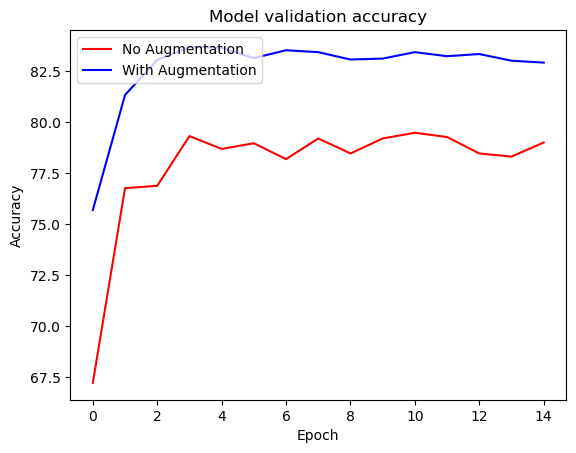

In [15]:
plt.plot(history_basic_aug['val_accuracy'], 'r', label='No Augmentation')
plt.plot(history_no_aug['val_accuracy'], 'b', label='With Augmentation')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [ ]:
plt.plot(history_basic_aug['val_accuracy'], 'r', label='No Augmentation')
plt.plot(history_no_aug['val_accuracy'], 'b', label='With Augmentation')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)
plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다.
plt.show()

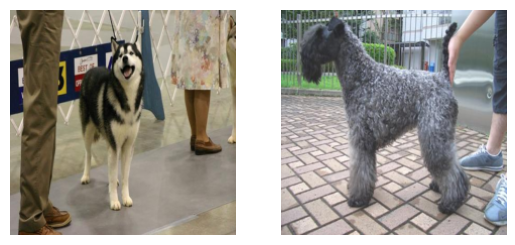

In [17]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다.
data_iter = iter(ds_train_no_aug)
images, labels = next(data_iter)

# 첫 번째 배치에서 두 개의 이미지 선택
image_a = images[0].permute(1, 2, 0).numpy()
image_b = images[1].permute(1, 2, 0).numpy()
label_a = labels[0].item()
label_b = labels[1].item()

# 정규화된 텐서를 다시 [0, 1] 범위로 조정
image_a = (image_a * 0.5) + 0.5
image_b = (image_b * 0.5) + 0.5

# 이미지 출력
plt.subplot(1, 2, 1)
plt.imshow(image_a)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_b)
plt.axis('off')

plt.show()

In [18]:
def get_clip_box(image_a, image_b):
    # image.shape = (channel, height, width)
    image_size_x = image_a.shape[2]  # Width
    image_size_y = image_a.shape[1]  # Height

    # Get center of box
    x = torch.randint(0, image_size_x, (1,)).item()
    y = torch.randint(0, image_size_y, (1,)).item()

    width = max(1, int(image_size_x * torch.sqrt(1 - torch.rand(1)).item()))
    height = max(1, int(image_size_y * torch.sqrt(1 - torch.rand(1)).item()))

    # Clip box in image and get minmax bbox
    x_min = max(0, x - width // 2)
    y_min = max(0, y - height // 2)
    x_max = min(image_size_x, x + width // 2 + 1)
    y_max = min(image_size_y, y + height // 2 + 1)

    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x :', x_min, x_max)
print('y :', y_min, y_max)

x : 0 3
y : 0 105


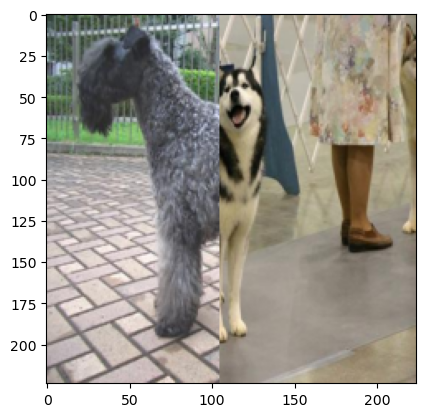

In [19]:
import torch

def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    # image.shape = (C, H, W)
    image_size_x = image_a.shape[2]  # Width
    image_size_y = image_a.shape[1]  # Height

    if isinstance(image_a, np.ndarray):
        image_a = torch.from_numpy(image_a).to(device)
    if isinstance(image_b, np.ndarray):
        image_b = torch.from_numpy(image_b).to(device)

    top = image_a[:, :y_min, :]
    middle_left = image_a[:, y_min:y_max, :x_min]
    middle_center = image_b[:, y_min:y_max, x_min:x_max]
    middle_right = image_a[:, y_min:y_max, x_max:]
    bottom = image_a[:, y_max:, :]

    top = top.to(device)
    middle_left = middle_left.to(device)
    middle_center = middle_center.to(device)
    middle_right = middle_right.to(device)
    bottom = bottom.to(device)

    # 중간 부분(왼쪽, 중앙, 오른쪽) 결합
    middle = torch.cat([middle_left, middle_center, middle_right], dim=2)

    # 전체 이미지 결합 (위 + 중간 + 아래)
    mixed_img = torch.cat([top, middle, bottom], dim=1)

    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)

plt.imshow(mixed_img.cpu().numpy())
plt.show()

In [20]:
import torch.nn.functional as F

# mix two labels
# 적절한 비율로 라벨을 합쳐줌
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[2]  # Width
    image_size_y = image_a.shape[1]  # Height

    # 바운딩 박스 비율 계산
    mixed_area = (x_max - x_min) * (y_max - y_min)
    total_area = image_size_x * image_size_y
    ratio = mixed_area / total_area

     # 원-핫 벡터 변환
    if isinstance(label_a, int):
        label_a = F.one_hot(torch.tensor(label_a), num_classes=num_classes).float()
    if isinstance(label_b, int):
        label_b = F.one_hot(torch.tensor(label_b), num_classes=num_classes).float()

    # 비율에 따라 라벨 혼합
    mixed_label = (1 - ratio) * label_a + ratio * label_b
    return mixed_label

# 예제 실행
mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
print(mixed_label)

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4688, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5312, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [21]:
def cutmix(images, labels, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = images[i]
        label_a = labels[i]

        j = torch.randint(0, batch_size, (1,)).item()  # 다른 샘플 선택
        image_b = images[j]
        label_b = labels[j]

        # 바운딩 박스 생성
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

        # 이미지 섞기
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes))

    # 텐서 변환
    mixed_imgs = torch.stack(mixed_imgs).reshape(batch_size, 3, img_size, img_size)
    mixed_labels = torch.stack(mixed_labels).reshape(batch_size, num_classes)

    return mixed_imgs, mixed_labels

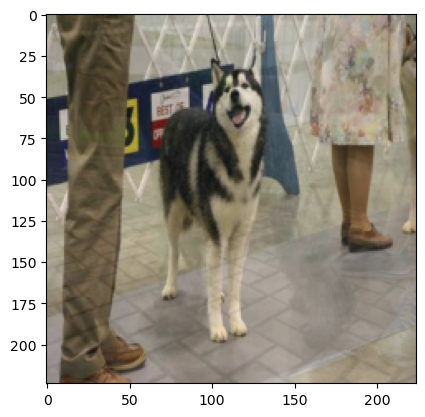

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1579, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.8421, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [22]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b, num_classes=120):
    ratio = torch.rand(1).item()  # 0~1 사이의 랜덤 값

    # 라벨 원핫 인코딩
    if isinstance(label_a, int):
        label_a = F.one_hot(torch.tensor(label_a), num_classes=num_classes).float()
    if isinstance(label_b, int):
        label_b = F.one_hot(torch.tensor(label_b), num_classes=num_classes).float()

    # 이미지와 라벨 혼합
    mixed_image = (1 - ratio) * image_a + ratio * image_b
    mixed_label = (1 - ratio) * label_a + ratio * label_b

    return mixed_image, mixed_label

# 예제 실행
mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)

plt.imshow(mixed_img)
plt.show()

print(mixed_label)

In [23]:
def mixup(images, labels, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = images[i]
        label_a = labels[i]

        # 랜덤하게 다른 이미지 선택
        j = torch.randint(0, batch_size, (1,)).item()
        image_b = images[j]
        label_b = labels[j]

        # Mixup 적용
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b, num_classes)

        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    # 배치 차원 추가
    mixed_imgs = torch.stack(mixed_imgs).view(batch_size, 3, img_size, img_size)  # (B, C, H, W)
    mixed_labels = torch.stack(mixed_labels).view(batch_size, num_classes)  # (B, num_classes)

    return mixed_imgs, mixed_labels

# CutMix 적용

In [24]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# 이미지 정규화 및 크기 조정
def normalize_and_resize_img(image, label):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # 크기 조정
        transforms.ToTensor(),  # Tensor 변환
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 정규화
    ])
    return transform(image), label

# 데이터 증강 (좌우 반전, 밝기 조정)
def augment(image, label):
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2),
        transforms.Lambda(lambda img: torch.clamp(img, 0, 1))  # 값 클리핑
    ])
    return transform(image), label

# 원-핫 인코딩
def onehot(label, num_classes=120):
    return torch.nn.functional.one_hot(torch.tensor(label), num_classes=num_classes).float()

# 데이터셋 적용
def apply_normalize_on_dataset(dataset, is_test=False, batch_size=16, with_aug=False, with_cutmix=False):
    dataset = [(normalize_and_resize_img(img, lbl)) for img, lbl in dataset]

    if not is_test and with_aug:
        dataset = [(augment(img, lbl)) for img, lbl in dataset]

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=not is_test, num_workers=2, pin_memory=True)

    if not is_test and with_cutmix:
        dataloader = [(cutmix(img, lbl)) for img, lbl in dataloader]
    else:
        dataloader = [(img, onehot(lbl)) for img, lbl in dataloader]

    return dataloader

In [25]:
# ===========================================
# ResNet-50 — Base+Mixup vs Base+CutMix (Full Script)
# ===========================================
import os, random, numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision import models

# -------------------------
# 0) Reproducibility & Device
# -------------------------
SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("[Info] device:", device)

# -------------------------
# 1) Datasets / Loaders
#    (원 코드 비율에 맞춰 58.3% / 41.7% split)
# -------------------------
dataset_dir = "data/Images/"   # data/Images/<class>/*.jpg
IMG_SIZE = 224
BATCH = 32
NUM_WORKERS = 2
PIN = (device == "cuda")

# 기본 전처리 (증강은 배치 레벨 Mixup/CutMix에서 적용)
# 원 코드와 동일하게 mean/std = 0.5 사용 (원하면 ImageNet 값으로 교체 가능)
tf_base = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
])

full = ImageFolder(dataset_dir, transform=tf_base)
num_classes = len(full.classes)
print("[Info] classes:", full.classes)

total = len(full)
train_len = max(1, int(0.583 * total))
test_len  = total - train_len
if test_len == 0:  # 데이터가 적을 때 대비
    test_len, train_len = 1, total - 1

gen = torch.Generator().manual_seed(SEED)
train_set, test_set = random_split(full, [train_len, test_len], generator=gen)

train_loader = DataLoader(train_set, batch_size=BATCH, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN)
test_loader  = DataLoader(test_set,  batch_size=BATCH, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN)

# -------------------------
# 2) Label utils + Categorical Cross-Entropy (soft labels)
# -------------------------
def one_hot(labels: torch.Tensor, num_classes: int) -> torch.Tensor:
    # labels: (B,)
    return F.one_hot(labels, num_classes=num_classes).float()

def categorical_cross_entropy(logits: torch.Tensor, target_probs: torch.Tensor) -> torch.Tensor:
    """
    Keras의 categorical_crossentropy와 동일한 형태:
    target_probs는 one-hot 또는 soft-label 분포
    """
    logp = F.log_softmax(logits, dim=1)
    return -(target_probs * logp).sum(dim=1).mean()

# -------------------------
# 3) Mixup & CutMix (배치 단위)
# -------------------------
def mixup_batch(images, labels, num_classes, alpha=1.0):
    """
    images: (B, C, H, W), labels: (B,)
    return: mixed_images, mixed_targets(one-hot/soft)
    """
    if alpha <= 0:
        return images, one_hot(labels, num_classes)

    lam = np.random.beta(alpha, alpha)
    index = torch.randperm(images.size(0), device=images.device)

    mixed_images = lam * images + (1 - lam) * images[index]
    y1 = one_hot(labels, num_classes)
    y2 = one_hot(labels[index], num_classes)
    mixed_targets = lam * y1 + (1 - lam) * y2
    return mixed_images, mixed_targets

def _rand_bbox(H, W, lam):
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)
    cx = np.random.randint(W)
    cy = np.random.randint(H)
    x1 = np.clip(cx - cut_w // 2, 0, W)
    y1 = np.clip(cy - cut_h // 2, 0, H)
    x2 = np.clip(cx + cut_w // 2, 0, W)
    y2 = np.clip(cy + cut_h // 2, 0, H)
    return x1, y1, x2, y2

def cutmix_batch(images, labels, num_classes, alpha=1.0):
    """
    images: (B, C, H, W), labels: (B,)
    return: mixed_images, mixed_targets(one-hot/soft)
    """
    if alpha <= 0:
        return images, one_hot(labels, num_classes)

    lam = np.random.beta(alpha, alpha)
    B, C, H, W = images.size()
    index = torch.randperm(B, device=images.device)

    x1, y1, x2, y2 = _rand_bbox(H, W, lam)
    mixed_images = images.clone()
    mixed_images[:, :, y1:y2, x1:x2] = images[index, :, y1:y2, x1:x2]

    # 실제 lambda를 영역 비율로 보정
    lam_adj = 1. - ((x2 - x1) * (y2 - y1) / (W * H))

    y1_oh = one_hot(labels, num_classes)
    y2_oh = one_hot(labels[index], num_classes)
    mixed_targets = lam_adj * y1_oh + (1 - lam_adj) * y2_oh
    return mixed_images, mixed_targets

# -------------------------
# 4) Model (ResNet-50)
# -------------------------
def build_resnet50(num_classes: int):
    try:
        m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    except Exception:
        # 오래된 torchvision 버전 호환
        m = models.resnet50(pretrained=True)
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

model_mixup  = build_resnet50(num_classes).to(device)
model_cutmix = build_resnet50(num_classes).to(device)

# -------------------------
# 5) Eval + Train(with history)
# -------------------------
@torch.no_grad()
def evaluate(model, loader, num_classes):
    model.eval()
    total, correct = 0, 0
    loss_sum = 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        # 검증셋은 혼합 없음 → one-hot로 소프트 CE 계산
        y_oh = one_hot(y, num_classes)
        loss = categorical_cross_entropy(logits, y_oh)

        loss_sum += loss.item() * x.size(0)
        total += y.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()

    val_acc = 100.0 * correct / total
    val_loss = loss_sum / total
    return val_acc, val_loss

def train_with_mixer(model, loader, mix_type, epochs=3, lr=3e-4, alpha=1.0, prob=1.0):
    """
    mix_type: 'mixup' or 'cutmix'
    returns: history dict like {'train_loss':[], 'train_acc':[], 'val_accuracy':[], 'val_loss':[]}
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    history = {'train_loss': [], 'train_acc': [], 'val_accuracy': [], 'val_loss': []}

    for ep in range(1, epochs+1):
        model.train()
        total, correct = 0, 0
        loss_sum = 0.0

        for x, y in loader:
            x, y = x.to(device), y.to(device)
            do_mix = (random.random() < prob)

            if mix_type == 'mixup' and do_mix:
                x_mix, y_mix = mixup_batch(x, y, num_classes=num_classes, alpha=alpha)
            elif mix_type == 'cutmix' and do_mix:
                x_mix, y_mix = cutmix_batch(x, y, num_classes=num_classes, alpha=alpha)
            else:
                x_mix, y_mix = x, one_hot(y, num_classes)

            logits = model(x_mix)
            loss = categorical_cross_entropy(logits, y_mix)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 통계
            bs = x.size(0)
            loss_sum += loss.item() * bs
            total += bs
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()  # 원라벨 기준 정확도

        train_loss = loss_sum / total
        train_acc = 100.0 * correct / total
        val_acc, val_loss = evaluate(model, test_loader, num_classes=num_classes)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_accuracy'].append(val_acc)   # 네가 쓰던 키 유지
        history['val_loss'].append(val_loss)

        print(f"[{mix_type.upper()}][Epoch {ep}] "
              f"train_loss={train_loss:.4f} | train_acc={train_acc:.2f}% | "
              f"val_loss={val_loss:.4f} | val_acc={val_acc:.2f}%")

    return history

# -------------------------
# 6) Run Experiments (and keep histories)
# -------------------------
EPOCHS = 15
ALPHA  = 1.0     # Beta(alpha, alpha)
PROB   = 1.0     # 적용 확률 (0~1)
LR     = 3e-4

print("\n=== Train: Base + Mixup ===")
history_mixup  = train_with_mixer(model_mixup,  train_loader, mix_type='mixup',
                                  epochs=EPOCHS, alpha=ALPHA, prob=PROB)

print("\n=== Train: Base + CutMix ===")
history_cutmix = train_with_mixer(model_cutmix, train_loader, mix_type='cutmix',
                                  epochs=EPOCHS, alpha=ALPHA, prob=PROB)

print("\n[Done] Last val_acc — Mixup:", history_mixup['val_accuracy'][-1],
      "| CutMix:", history_cutmix['val_accuracy'][-1])

# (선택) 저장
# torch.save(model_mixup.state_dict(),  "resnet50_base_mixup.pth")
# torch.save(model_cutmix.state_dict(), "resnet50_base_cutmix.pth")


[Info] device: cuda
[Info] classes: ['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier', 'n02093754-Border_terrier', 'n02093859-Kerry_blue_terrier', 'n02093991-Irish_terrier', 'n02094114-Norfolk_terrier', 'n02094258-Norw

In [26]:
# ===========================================
# 0) 히스토리 요약 + 표/그래프 출력 유틸
# ===========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def summarize_histories(histories, labels, sort_by="best_val_acc", baseline_label="No Aug"):
    """
    histories: [h1, h2, ...]  (각 h는 {'train_loss','train_acc','val_loss','val_accuracy'} 리스트를 포함)
    labels   : ["No Aug", "Basic Aug", "Basic+Mixup", "Basic+CutMix"]
    """
    rows = []
    for name, h in zip(labels, histories):
        val = h["val_accuracy"]
        train = h.get("train_acc", [np.nan]*len(val))
        best_idx = int(np.argmax(val))
        rows.append({
            "setting": name,
            "best_val_acc": float(val[best_idx]),
            "best_epoch": best_idx + 1,
            "last_val_acc": float(val[-1]),
            "last_train_acc": float(train[-1]) if len(train) == len(val) else np.nan
        })
    df = pd.DataFrame(rows)

    # 기준 대비 향상치(+/-) 계산
    if baseline_label in df["setting"].values:
        base = df.loc[df["setting"] == baseline_label, "best_val_acc"].iloc[0]
        df["lift_vs_baseline"] = df["best_val_acc"] - base
    else:
        df["lift_vs_baseline"] = np.nan

    df = df.sort_values(sort_by, ascending=False).reset_index(drop=True)

    # 보기 좋게 포맷해 출력
    fmt = {
        "best_val_acc": "{:.2f}%".format,
        "last_val_acc": "{:.2f}%".format,
        "last_train_acc": "{:.2f}%".format,
        "lift_vs_baseline": lambda x: (f"{x:+.2f}%" if pd.notnull(x) else "")
    }
    print("\n=== Summary (by {}) ===".format(sort_by))
    print(df.to_string(index=False, formatters=fmt))
    return df

def plot_best_val_bar(df):
    plt.figure(figsize=(7,4))
    order = df.sort_values("best_val_acc", ascending=False)
    plt.bar(order["setting"], order["best_val_acc"])
    plt.ylim(0, 100)
    plt.ylabel("Best Val Acc (%)")
    plt.title("ResNet-50 Breed Classification — Best Validation Accuracy")
    for i, v in enumerate(order["best_val_acc"]):
        plt.text(i, v + 1, f"{v:.1f}%", ha="center", va="bottom", fontsize=9)
    plt.tight_layout()
    plt.show()


In [27]:
# ===========================================
# 동일 Test Loader로 최종 재평가
# - 학습 중 기록된 val과 별도로, 현재 가중치 기준으로 다시 한 번 클린 테스트 평가
# ===========================================
@torch.no_grad()
def evaluate_clean(model, loader, num_classes):
    model.eval()
    total, correct = 0, 0
    loss_sum = 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        y_oh = one_hot(y, num_classes)           # 소프트 CE
        loss = categorical_cross_entropy(logits, y_oh)
        loss_sum += loss.item() * x.size(0)
        total += y.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
    return 100.0 * correct / total, loss_sum / total



=== Summary (by best_val_acc) ===
     setting best_val_acc  best_epoch last_val_acc last_train_acc lift_vs_baseline
      No Aug       83.70%           4       82.93%            NaN           +0.00%
   Basic Aug       79.49%          11       79.01%            NaN           -4.21%
Basic+CutMix       65.54%          14       62.78%         62.69%          -18.15%
 Basic+Mixup       61.19%          14       58.82%         51.22%          -22.51%


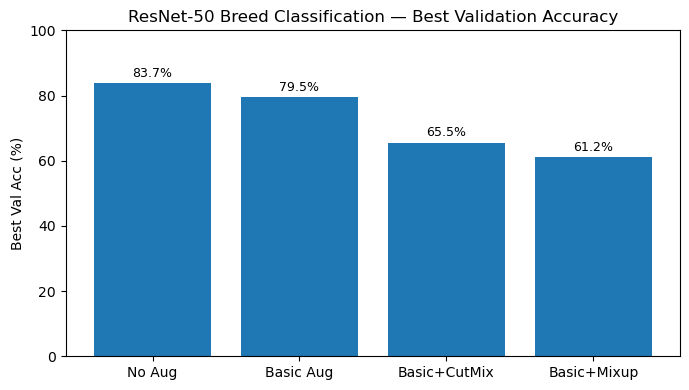


=== Final Clean Test (re-eval) ===
[      No Aug] Test Acc= 82.93% | Test Loss=0.6022
[   Basic Aug] Test Acc= 79.01% | Test Loss=0.6850
[ Basic+Mixup] Test Acc= 58.82% | Test Loss=1.6751
[Basic+CutMix] Test Acc= 62.78% | Test Loss=1.4849


In [29]:
# ===========================================
# 2) 요약 실행부
# ===========================================
# 학습한 4개 히스토리와 모델을 이렇게 가정
# history_no_aug, history_basic_aug, history_mixup, history_cutmix
# model_no_aug,  model_basic_aug,  model_mixup,  model_cutmix

histories = [
    history_no_aug,        # No Aug
    history_basic_aug,     # Basic Aug
    history_mixup,         # Basic + Mixup
    history_cutmix         # Basic + CutMix
]
labels = ["No Aug", "Basic Aug", "Basic+Mixup", "Basic+CutMix"]

df_summary = summarize_histories(histories, labels, sort_by="best_val_acc", baseline_label="No Aug")
plot_best_val_bar(df_summary)

# 동일 테스트셋으로 최종 모델 정확도/로스 재평가
final_tests = [
    ("No Aug",        model_no_aug),
    ("Basic Aug",     model_aug),
    ("Basic+Mixup",   model_mixup),
    ("Basic+CutMix",  model_cutmix),
]
print("\n=== Final Clean Test (re-eval) ===")
for name, model in final_tests:
    acc, loss = evaluate_clean(model, test_loader, num_classes=num_classes)
    print(f"[{name:>12}] Test Acc={acc:6.2f}% | Test Loss={loss:.4f}")
